Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1024, 1024])


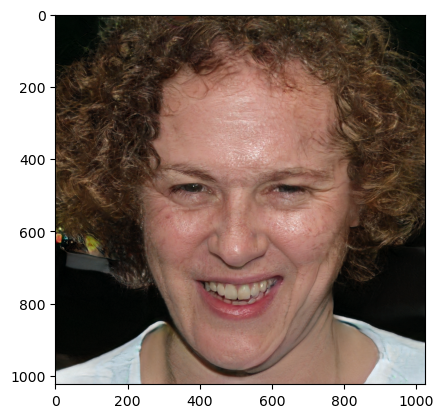

In [2]:
from models.stylegan_layers import G_synthesis, G_mapping
from collections import OrderedDict
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
# set torch random seed

np.random.seed(3)

resolution=1024
weight_file="weight_files/pytorch/karras2019stylegan-ffhq-1024x1024_g.pt"
drange = [-1,1]

g_all = nn.Sequential(OrderedDict([
('g_mapping', G_mapping()),
#('truncation', Truncation(avg_latent)),
('g_synthesis', G_synthesis(resolution=resolution))    
]))

# print(g_all)
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)

random_latents = torch.tensor(np.random.randn(1, 512).astype(np.float32)).to(device)
# print(random_latents.shape)
images = g_all(random_latents)
images = (images+1) / 2
print(images.shape)
plt.imshow(images[0].permute(1,2,0).detach().cpu().numpy())
plt.show(block=False)

In [ ]:
def decode_images()

In [3]:
# import discriminator from models.stylegan_layers
from models.stylegan_layers import D_basic
d_weight_file="weight_files/pytorch/karras2019stylegan-ffhq-1024x1024_d.pt"
d_basic=D_basic(resolution=resolution,).to(device)
d_basic.load_state_dict(torch.load(d_weight_file, map_location=device))
d_basic.eval()

D_basic(
  (fromrgb): MyConv2d()
  (act): LeakyReLU(negative_slope=0.2)
  (1024x1024): DiscriminatorBlock(
    (conv0): MyConv2d()
    (act0): LeakyReLU(negative_slope=0.2)
    (blur): BlurLayer()
    (conv1_down): MyConv2d(
      (downscale): Downscale2d(
        (blur): BlurLayer()
      )
    )
    (act1): LeakyReLU(negative_slope=0.2)
  )
  (512x512): DiscriminatorBlock(
    (conv0): MyConv2d()
    (act0): LeakyReLU(negative_slope=0.2)
    (blur): BlurLayer()
    (conv1_down): MyConv2d(
      (downscale): Downscale2d(
        (blur): BlurLayer()
      )
    )
    (act1): LeakyReLU(negative_slope=0.2)
  )
  (256x256): DiscriminatorBlock(
    (conv0): MyConv2d()
    (act0): LeakyReLU(negative_slope=0.2)
    (blur): BlurLayer()
    (conv1_down): MyConv2d(
      (downscale): Downscale2d(
        (blur): BlurLayer()
      )
    )
    (act1): LeakyReLU(negative_slope=0.2)
  )
  (128x128): DiscriminatorBlock(
    (conv0): MyConv2d()
    (act0): LeakyReLU(negative_slope=0.2)
    (blur): Bl

#### Analysis of Discriminator with courrupted images

In [4]:
d_basic(images*2-1).detach().cpu().numpy().flatten()[0]

-8.225817

##### 1. Gaussian Noise

Text(0.5, 1.0, 'Pepper Noise')

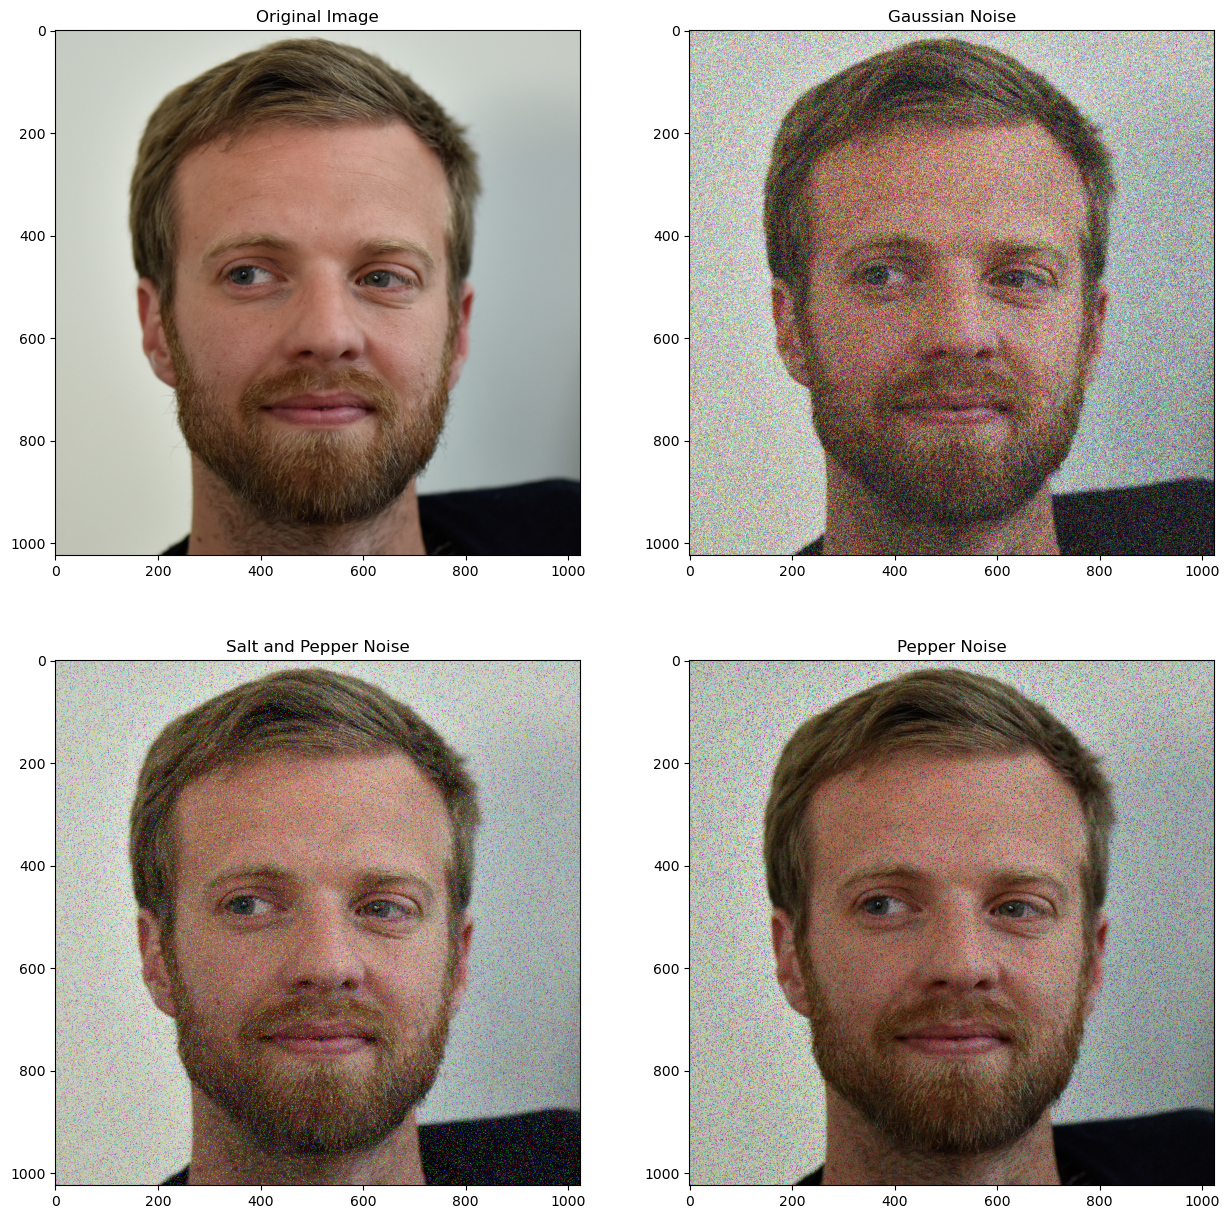

In [12]:
import numpy as np
import os
import cv2
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import skimage

def add_gaussian_noise(img, mean=0, var=0.1,seed=1):
    if isinstance(img,Image.Image):
        img = np.array(img)/255
    noisey_img = skimage.util.random_noise(img, mode='gaussian',mean=mean,var=var,seed=1, clip=True)
    return noisey_img

def add_salt_pepper_noise(img, amount=0.1,seed=1):
    if isinstance(img,Image.Image):
        img = np.array(img)/255
    noisey_img = skimage.util.random_noise(img, mode='s&p',amount=amount,seed=seed, clip=True)
    return noisey_img

def add_pepper_noise(img, amount=0.1,seed=1):
    if isinstance(img,Image.Image):
        img = np.array(img)/255
    noisey_img = skimage.util.random_noise(img, mode='pepper',amount=amount,seed=seed, clip=True)
    return noisey_img

img = cv2.imread("./source_image/63948.png")/255
# image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(2,2, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(img[...,::-1])
ax[0].set_title("Original Image")
ax[1].imshow(add_gaussian_noise(img)[...,::-1])
ax[1].set_title("Gaussian Noise")
ax[2].imshow(add_salt_pepper_noise(img)[...,::-1])
ax[2].set_title("Salt and Pepper Noise")
ax[3].imshow(add_pepper_noise(img)[...,::-1])
ax[3].set_title("Pepper Noise")

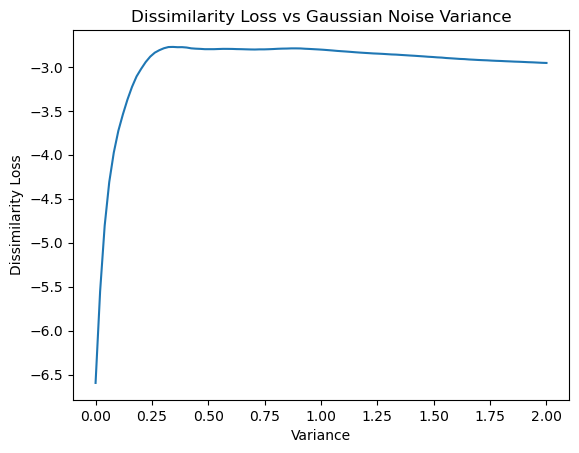

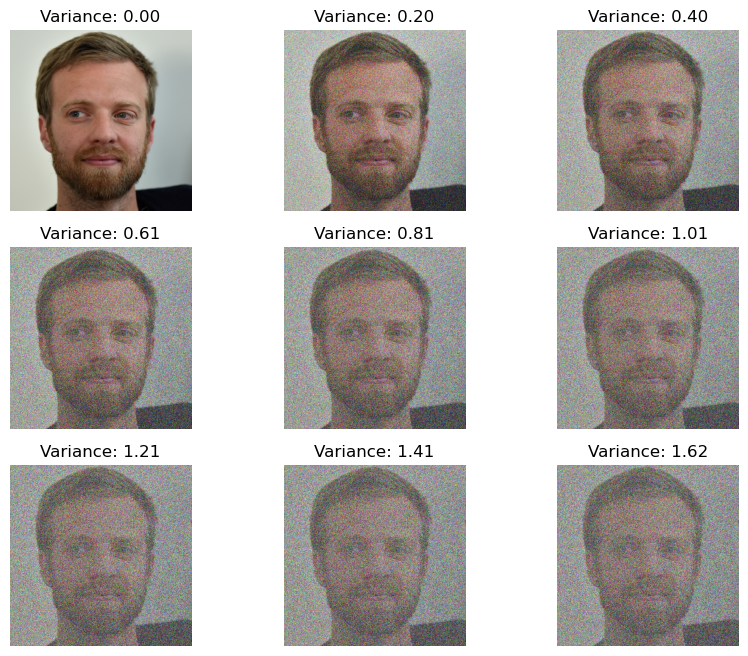

In [13]:
vars = np.linspace(0,2,100)
diss_loss = []
sample_imgs =[]
for idx,var in enumerate(vars):
    noisey_img=add_gaussian_noise(img, var=var)
    if idx % 10 == 0:
        sample_imgs.append(noisey_img)
    noisey_img = noisey_img.astype(np.float32) 
    noisey_img = noisey_img * (drange[1] - drange[0]) + drange[0]
    noisey_img = torch.tensor(noisey_img).permute(2,0,1).unsqueeze(0).to(device) 
    diss_loss.append(d_basic(noisey_img).detach().cpu().numpy().flatten()[0])
plt.title("Dissimilarity Loss vs Gaussian Noise Variance")
plt.xlabel("Variance")
plt.ylabel("Dissimilarity Loss")
plt.plot(vars, diss_loss)
plt.show()

row,col =3,3
fig, ax = plt.subplots(row,col, figsize=(10,8))
ax = ax.flatten()
for idx, img_ in enumerate(sample_imgs):
    ax[idx].imshow(img_[...,::-1])
    ax[idx].set_title("Variance: {:.2f}".format(vars[idx*10]))
    ax[idx].axis('off')
    if idx == row*col-1:
        break

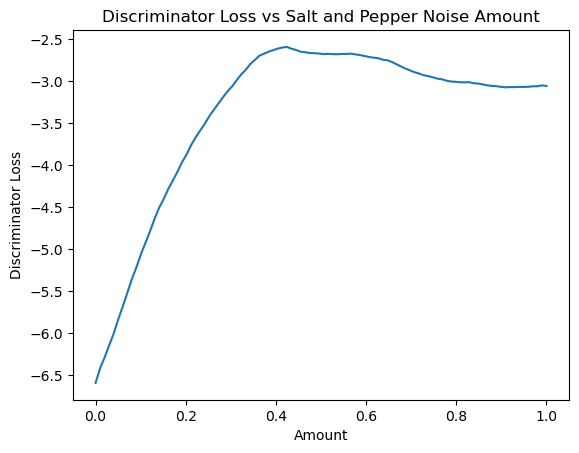

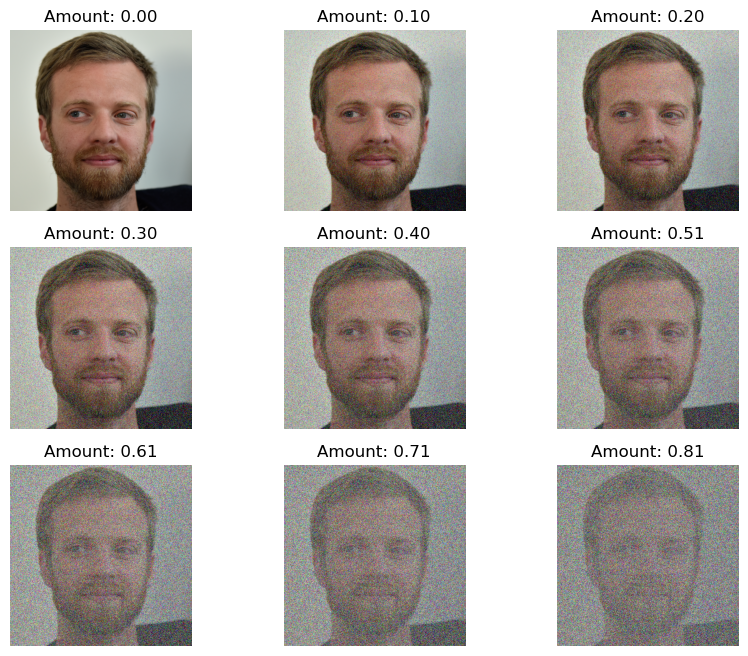

In [14]:
amounts = np.linspace(0,1,100)
diss_loss = []
sample_imgs =[]
for idx,amount in enumerate(amounts):
    noisey_img=add_salt_pepper_noise(img, amount=amount)
    if idx % 10 == 0:
        sample_imgs.append(noisey_img)
    noisey_img = noisey_img.astype(np.float32) 
    noisey_img = noisey_img * (drange[1] - drange[0]) + drange[0]
    noisey_img = torch.tensor(noisey_img).permute(2,0,1).unsqueeze(0).to(device) 
    diss_loss.append(d_basic(noisey_img).detach().cpu().numpy().flatten()[0])
plt.title("Discriminator Loss vs Salt and Pepper Noise Amount")
plt.xlabel("Amount")
plt.ylabel("Discriminator Loss")
plt.plot(amounts, diss_loss)
plt.show()

row,col =3,3
fig, ax = plt.subplots(row,col, figsize=(10,8))
ax = ax.flatten()
for idx, img_ in enumerate(sample_imgs):
    ax[idx].imshow(img_[...,::-1])
    ax[idx].set_title("Amount: {:.2f}".format(amounts[idx*10]))
    ax[idx].axis('off')
    if idx == row*col-1:
        break

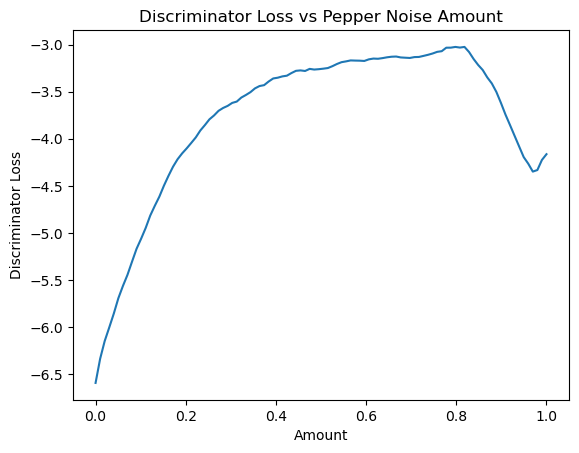

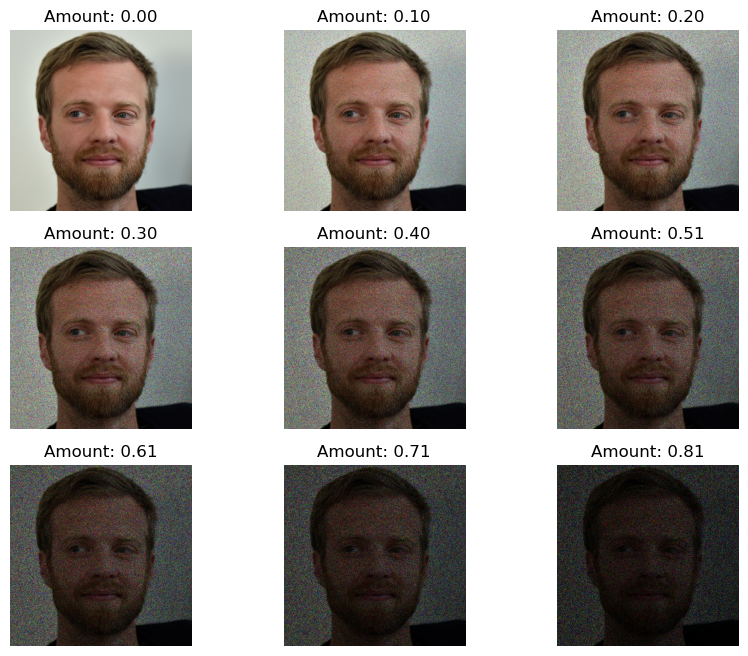

In [15]:
amounts = np.linspace(0,1,100)
diss_loss = []
sample_imgs =[]
for idx,amount in enumerate(amounts):
    noisey_img=add_pepper_noise(img, amount=amount)
    if idx % 10 == 0:
        sample_imgs.append(noisey_img)
    noisey_img = noisey_img.astype(np.float32) 
    noisey_img = noisey_img * (drange[1] - drange[0]) + drange[0]
    noisey_img = torch.tensor(noisey_img).permute(2,0,1).unsqueeze(0).to(device) 
    diss_loss.append(d_basic(noisey_img).detach().cpu().numpy().flatten()[0])
plt.title("Discriminator Loss vs Pepper Noise Amount")
plt.xlabel("Amount")
plt.ylabel("Discriminator Loss")
plt.plot(amounts, diss_loss)
plt.show()

row,col =3,3
fig, ax = plt.subplots(row,col, figsize=(10,8))
ax = ax.flatten()
for idx, img_ in enumerate(sample_imgs):
    ax[idx].imshow(img_[...,::-1])
    ax[idx].set_title("Amount: {:.2f}".format(amounts[idx*10]))
    ax[idx].axis('off')
    if idx == row*col-1:
        break

##### 2. Noise Image Jpeg comprasion artifact Analysis on discriminator

In [1]:
import cv2 

img = cv2.imread("./source_image/63948.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB,)
plt.imshow(img)

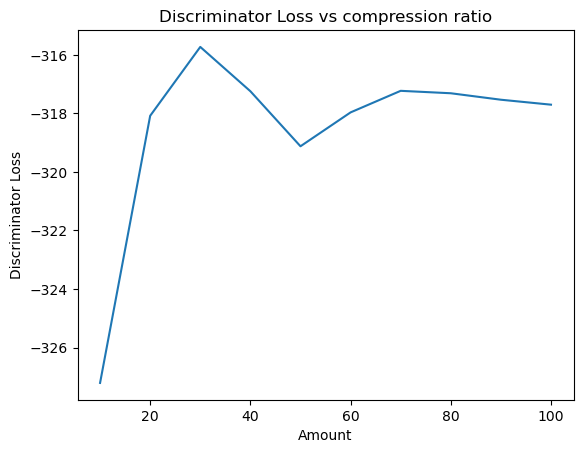

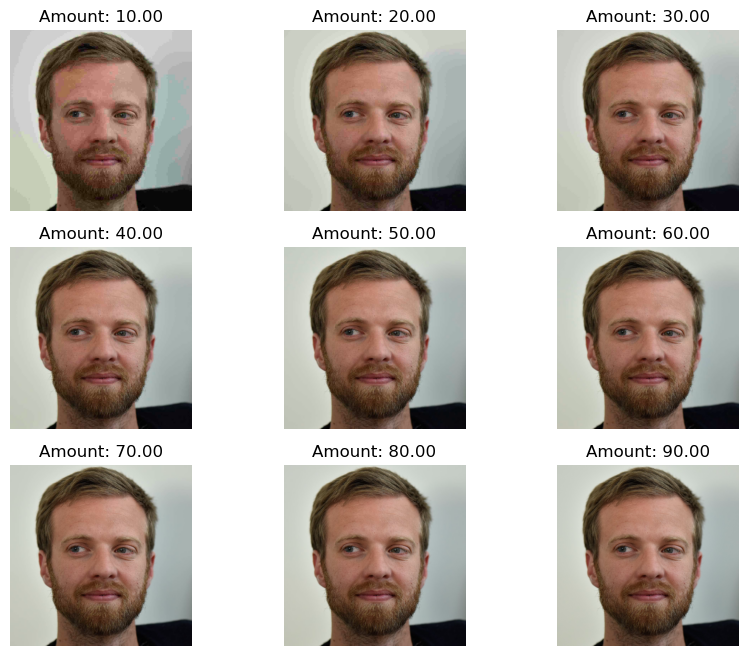

In [18]:
cr_ratios = np.linspace(10,100,10)
diss_loss = []
sample_imgs =[]
for idx,cr_ratio in enumerate(cr_ratios):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), cr_ratio]
    result,enc_img = cv2.imencode('.jpg', img, encode_param)
    noisey_img = cv2.imdecode(enc_img, 1)
    sample_imgs.append(noisey_img)
    noisey_img = noisey_img.astype(np.float32) 
    noisey_img = noisey_img * (drange[1] - drange[0]) + drange[0]
    noisey_img = torch.tensor(noisey_img).permute(2,0,1).unsqueeze(0).to(device) 
    diss_loss.append(d_basic(noisey_img).detach().cpu().numpy().flatten()[0])
plt.title("Discriminator Loss vs compression ratio")
plt.xlabel("Amount")
plt.ylabel("Discriminator Loss")
plt.plot(cr_ratios, diss_loss)
plt.show()

row,col =3,3
fig, ax = plt.subplots(row,col, figsize=(10,8))
ax = ax.flatten()
for idx, img_ in enumerate(sample_imgs):
    ax[idx].imshow(img_)
    ax[idx].set_title("Amount: {:.2f}".format(cr_ratios[idx]))
    ax[idx].axis('off')
    if idx == row*col-1:
        break


##### Upscaling Using Bicubic Artifacts Discriminator